In [283]:
import ira
%alphalab dark

%run initlibs.py Lustre dark
from tools.loaders.data_loaders import load_data
from tools.charting.signals_charts import plot_entries

import qlearn as q

%run trackers.py

# Indicator and some charts

In [208]:
d = load_data('amp:SPXM')

For testing RAD tracker purposes we generate entry signals manually.
Then we will run backtesting of these signals on historical data without and with RAD tracker.

Actual code of RAD tracker can be found in **trackers.py**.

In [355]:
signals = pd.DataFrame.from_dict({
    '2020-10-01 10:00':  0,   # start from positiom 0
    '2020-10-05 10:00': +1,   # buy signal
    '2020-10-08 10:00': +1,   # another buy signal
    '2020-10-14 10:00': -1,   # sell (reverse) trade
    '2020-10-20 10:00':  0    # close all positions
}, orient='index', columns=[d.symbol])

signals.index = pd.to_datetime(signals.index)

In [350]:
r = q.simulation({
    'Signals without RAD': [signals, q.FixedTrader(100, 0, 0)],
    'Signals RAD stop':    [signals, RADChandelier(100, '1h', 24, 3, debug=True)]
}, d.ohlcs('5Min'), 'stock', 'RADTests', spreads=0.5)

[2020-10-05 09:59:00] SPXM entry long at $3370.55 stop to 3331.725
[2020-10-05 10:00:00] SPXM pull up stop to 3332.075
[2020-10-05 11:00:00] SPXM pull up stop to 3334.0875
[2020-10-05 12:00:00] SPXM pull up stop to 3335.675
[2020-10-05 13:00:00] SPXM pull up stop to 3336.8624999999997
[2020-10-05 14:00:00] SPXM pull up stop to 3342.1125
[2020-10-05 15:00:00] SPXM pull up stop to 3357.9625
[2020-10-05 16:00:00] SPXM pull up stop to 3362.3625
[2020-10-05 17:00:00] SPXM pull up stop to 3365.1
[2020-10-05 18:00:00] SPXM pull up stop to 3368.8
[2020-10-05 19:00:00] SPXM pull up stop to 3372.4875
[2020-10-05 20:00:00] SPXM pull up stop to 3380.7625000000003
[2020-10-05 22:00:00] SPXM pull up stop to 3382.425
[2020-10-05 23:00:00] SPXM pull up stop to 3383.55
[2020-10-06 00:00:00] SPXM pull up stop to 3384.1875
[2020-10-06 03:00:00] SPXM pull up stop to 3384.7125
[2020-10-06 05:00:00] SPXM pull up stop to 3385.2250000000004
[2020-10-06 06:00:00] SPXM pull up stop to 3385.375
[2020-10-06 09:00

As we can see tracker worked as expected and pulled up/down stop levels on new updates.

We can visually compare cumulative PnLs for both backtests:

 0: RADTests/Signals without RAD  : Sharpe: 5.78 | Sortino: 16.13 | CAGR: 223602954.99 | DD: $8560.00 (53.90%) | Gain: $21910.00 | Execs: 3[OK]
 1: RADTests/Signals RAD stop     : Sharpe: 6.15 | Sortino: 19.66 | CAGR: 7184236.85 | DD: $5290.00 (33.31%) | Gain: $14290.00 | Execs: 6[OK]


,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,RADTests/Signals without RAD,5.779615,16.130637,2.236030e+08,8560.0,53.904282,21910.0,3
1,RADTests/Signals RAD stop,6.153806,19.661174,7.184237e+06,5290.0,33.312343,14290.0,6


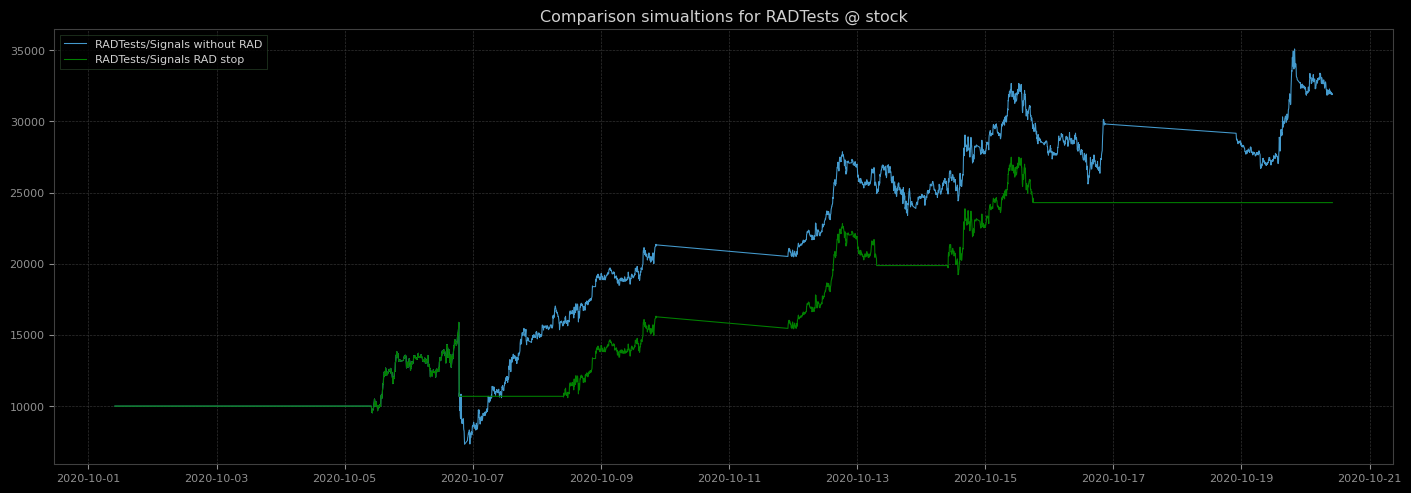

In [357]:
fig(18, 6)
r.report(10000)

Let's look at executions and try to plot them on ohlc chart

In [352]:
r.results[1].executions

,instrument,quantity,exec_price,comment
2020-10-05 10:00:00,SPXM,100,3370.55,
2020-10-06 18:54:00,SPXM,-100,3377.45,stop long at 3377.95
2020-10-08 10:00:00,SPXM,100,3427.95,
2020-10-13 07:19:00,SPXM,-100,3519.75,stop long at 3520.25
2020-10-14 10:00:00,SPXM,-100,3521.05,
2020-10-15 18:04:00,SPXM,100,3476.85,stop short at 3476.35


In [353]:
rc = rad_indicator(x, 24, 3)

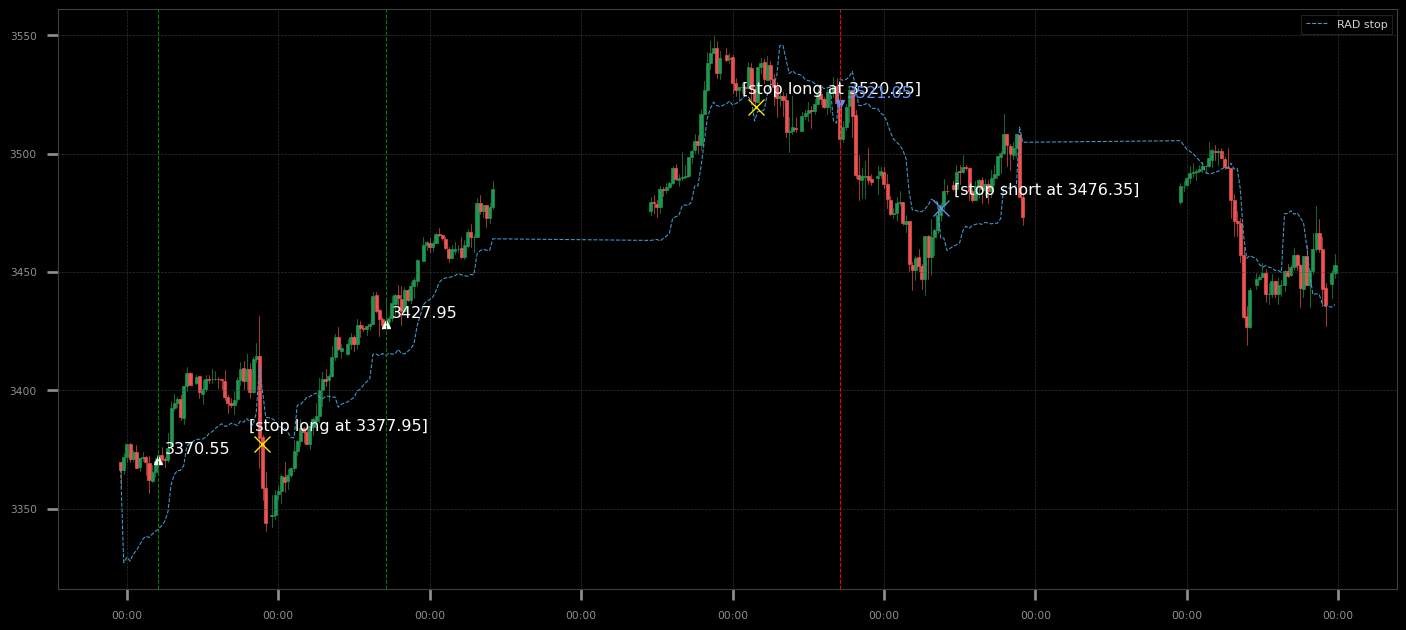

In [358]:
_z = slice('2020-10-03 10:00', '2020-10-20')
fig(18, 8)
ohlc_plot(x[_z])
plt.plot(rc.rad[_z], ls='--', label='RAD stop'); plt.legend();
plot_entries(r.results[1].executions, None)

for t, s in signals[d.symbol].items():
    if s != 0: plt.axvline(t, ls='--', c='r' if s < 0 else 'g')